# Predicting CO2 Emission Per Capita for a country using energy consumptions

by Tony Shum, Jing Wen, Aishwarya Nadimpally, Weilin Han

In [1]:
# Initialize packages
import pandas as pd
import altair as alt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer,mean_squared_error,r2_score
import matplotlib.pyplot as plt

In [2]:
# Import the functions from the src folder
import sys
import os

# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append(os.path.join('..'))
from src.create_scatter_plot import create_scatter_plot
from src.data_preprocessor import data_preprocessor
from src.read_melt_merge import read_melt_merge
from src.scoring_metrics import scoring_metrics

# Summary

Here we attempt to build a prediction model using the k-nearest neighbours algorithm which can use energy consumption and energy generation measurements to predict CO2 emission of certain country of next year. Our final prediction model perform pretty well on unseen test dataset, with $\text{R}^2$ of 0.975 and an overall accuracy calculated to be 0.976. However, the model predict CO2 emission by finding the existing cases in the training data set which is most similiar to unseen data, thus, if there is a case in unseen data set of which measurements are beyond the ranges in training data set (ie. massive increase of energy usage or energy efficiency increase or new type of clean energy), then the prediciton might not be accurate, thus we recomment continuing study to improve this prediction model.

# Introduction


According to the intergovernmental panel on climate change (IPCC), CO2 emissions are a leading contributor to global warming and climate change (IPCC, 2014). Understanding the correlation between consumption of different types of energy and CO2 emission is critical for formulating policies aimed at reducing emissions and mitigating climate change impacts (IPCC, 2018).

Our project aims to estimate a machine learning model to use energy consumptions per capita to predict CO2 Emission per capita of a country. Our model can be a powerful tool for raising public awareness of the impact of energy consumption on CO2 emission and international agreements on emission reductions. We are hoping that our findings will encourage sustainable behavior, such as reducing energy consumption or opting for green energy alternatives (International Energy Agency, 2018). 


# Methods

<!-- BEGIN QUESTION -->


## Data

The data set that was used in this project is from World Bank via GAPMINDER.ORG, which is an independent Swedish foundation with no political, religious or economic affiliations and the link can be found https://www.gapminder.org/


##### Credential
    
FREE DATA FROM WORLD BANK VIA GAPMINDER.ORG, CC-BY LICENSE

## Analysis

Data was split with 80% partitioned as training data and 20% as test data. For model building, we have chosen KNeighborsRegressor (KNN) from DummyRegressor,Ridge, SVR, as we have the highest $\text{R}^2$ score for KNN. The hyperparameter $K$ was chosen using 10-fold cross validation with $R^2$ as the regression metric.

# Results & Discussions

Our prediction model performed well on test data, with a final overall $\text{R}^2$ of 0.976, which is promising for predicting a country's CO2 emission per capita given the energy generation and consumption data. Our model has small deviation from residual to the ground truth, as we have RMSE of 1.34 meaning that our model is relatively accurate in terms of CO2 emission prediction.

In [3]:
# read datasets and melt dataframe from wide table to long table
#merging data
data_files_names = [
    "co2_emissions_tonnes_per_person",
    "coal_consumption_per_cap",
    "electricity_generation_per_person",
    "electricity_use_per_person",
    "hydro_power_generation_per_person",
    "nuclear_power_generation_per_person",
    "natural_gas_production_per_person",
    "oil_consumption_per_cap",
    "oil_production_per_person",
]
col_names = [
    "co2_e",
    "coal_c",
    "elec_g",
    "elec_c",
    "hydro_g",
    "nuclear_g",
    "gas_g",
    "oil_c",
    "oil_g",
]

# function 1
merged_df = read_melt_merge(
    data_files_names, col_names, id_variable="country", variable_name="year"
)
merged_df

,country,year,co2_e,coal_c,elec_g,elec_c,hydro_g,nuclear_g,gas_g,oil_c,oil_g
0,Afghanistan,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Angola,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UAE,1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42803,Yemen,2019,NaN,NaN,NaN,NaN,NaN,NaN,0.017,NaN,0.145
42804,Zambia,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42805,Zimbabwe,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42806,Equatorial Guinea,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.040


In [4]:
#EDA to remove years and countries with too many NaN
cleaned_df = merged_df.query('not co2_e.isna() and not coal_c.isna() and not elec_c.isna() and not oil_c.isna()')
# remove rows that co2_e, coal_c, elec_c and oil_c do not have na value. But we think it's acceptable that elec_g, hydro_g, nuclear_g and gas_g have na value. 
# Filling NaN with 0.
cleaned_df = cleaned_df.fillna(0)
cleaned_df = cleaned_df.reset_index().drop(columns='index')
cleaned_df

,country,year,co2_e,coal_c,elec_g,elec_c,hydro_g,nuclear_g,gas_g,oil_c,oil_g
0,Australia,1965,10.70,1.54,0,2630,0.0628,0,0.000,1.340,0.0306
1,Austria,1965,5.23,0.696,0,2310,0.186,0,0.000,0.761,0.0000
2,Belgium,1965,11.20,2.03,0,2160,0.00248,0,0.000,1.690,0.0000
3,Canada,1965,12.80,0.788,0,6910,0.516,0.00056,0.000,2.740,2.2400
4,Switzerland,1965,5.22,0.219,0,3590,0.364,0,0.000,1.380,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
3340,South Africa,2014,8.86,1.64,4670,4180,0,0,0.000,0.485,0.0000
3341,Indonesia,2015,1.96,0.198,906,910.0,0,0,0.253,0.271,0.1570
3342,Indonesia,2016,2.15,0.204,948,956.0,0,0,0.247,0.269,0.1640
3343,Indonesia,2017,2.21,0.216,962,1020.0,0,0,0.236,0.280,0.1550


In [5]:
# save dataframe
cleaned_df.to_csv('../data/processed/save_the_earth_processed_data.csv', index=True)

In [6]:
# read data
df = pd.read_csv("../data/processed/save_the_earth_processed_data.csv", index_col=0)

#### Exploratory Data Analysis (EDA)

From our data, we have no NA or missing data, but need to change the data type of No. 3 column to No. 7 column to float. We also need need to clean up data and unify the units, such change 20u to 20e-6 and 15.1k to 15.1e3.

In [7]:
# Column data types and information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3345 entries, 0 to 3344
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    3345 non-null   object 
 1   year       3345 non-null   int64  
 2   co2_e      3345 non-null   float64
 3   coal_c     3345 non-null   object 
 4   elec_g     3345 non-null   object 
 5   elec_c     3345 non-null   object 
 6   hydro_g    3345 non-null   object 
 7   nuclear_g  3345 non-null   object 
 8   gas_g      3345 non-null   float64
 9   oil_c      3345 non-null   float64
 10  oil_g      3345 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 313.6+ KB


#### Cleaning up of Data

In [8]:
# covert column data type
cols_to_convert = df.columns[3:8]

# unify the units, e.g. ug to g; kg to g
df[cols_to_convert] = df[cols_to_convert].replace(to_replace=r'(\d+)µ', value=r'\1e-6', regex=True)
df[cols_to_convert] = df[cols_to_convert].replace(to_replace=r'(\d+(?:\.\d+)?)k', value=r'\1e3', regex=True)

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3345 entries, 0 to 3344
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    3345 non-null   object 
 1   year       3345 non-null   int64  
 2   co2_e      3345 non-null   float64
 3   coal_c     3345 non-null   float64
 4   elec_g     3345 non-null   float64
 5   elec_c     3345 non-null   float64
 6   hydro_g    3345 non-null   float64
 7   nuclear_g  3345 non-null   float64
 8   gas_g      3345 non-null   float64
 9   oil_c      3345 non-null   float64
 10  oil_g      3345 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 313.6+ KB


#### Split the data

In [9]:
# split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df

,country,year,co2_e,coal_c,elec_g,elec_c,hydro_g,nuclear_g,gas_g,oil_c,oil_g
119,Italy,1969,5.08,0.1840,0.0,1930.0,0.06680,0.00273,0.0000,1.450,0.0299
2559,Vietnam,2004,1.06,0.1070,556.0,488.0,0.01860,0.00000,0.0416,0.150,0.2460
353,Australia,1974,12.70,1.6700,0.0,4580.0,0.08290,0.00000,0.3390,2.170,1.4800
1889,Hungary,1996,6.12,0.4150,3400.0,3160.0,0.00173,0.11800,0.0000,0.681,0.0000
48,Portugal,1966,1.34,0.0685,0.0,543.0,0.05120,0.00000,0.0000,0.298,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2154,Romania,1999,4.07,0.3150,2270.0,1940.0,0.07060,0.02010,0.5020,0.425,0.2860
3089,Qatar,2011,39.20,0.0000,15100.0,16000.0,0.00000,0.00000,63.5000,3.920,38.2000
1766,Saudi Arabia,1994,16.90,0.0000,5820.0,4790.0,0.00000,0.00000,1.9200,3.460,23.7000
1122,Slovak Republic,1985,11.50,1.6400,4360.0,4840.0,0.03540,0.15700,0.0000,1.200,0.0000


In [10]:
train_df.shape

(2676, 11)

In [11]:
test_df.shape

(669, 11)

In [12]:
# statistical summary for all numeric columns
train_df.describe(include='all')

,country,year,co2_e,coal_c,elec_g,elec_c,hydro_g,nuclear_g,gas_g,oil_c,oil_g
count,2676,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000
unique,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1992.194694,8.407374,0.529499,3855.268834,4655.488341,0.118633,0.043670,1.126443,1.434458,4.130119
std,NaN,13.526486,8.757477,0.815835,5660.509816,5257.367014,0.347776,0.108274,4.095097,1.428530,16.438382
min,NaN,1965.000000,0.052700,0.000000,0.000000,10.200000,0.000000,0.000000,0.000000,0.010300,0.000000
25%,NaN,1981.000000,3.270000,0.018375,0.000000,1220.000000,0.000600,0.000000,0.000000,0.460500,0.000000
50%,NaN,1993.000000,6.730000,0.212500,1950.000000,3210.000000,0.014800,0.000000,0.000000,1.100000,0.000000
75%,NaN,2004.000000,10.500000,0.741500,5615.000000,6062.500000,0.065625,0.006850,0.485500,1.970000,1.292500


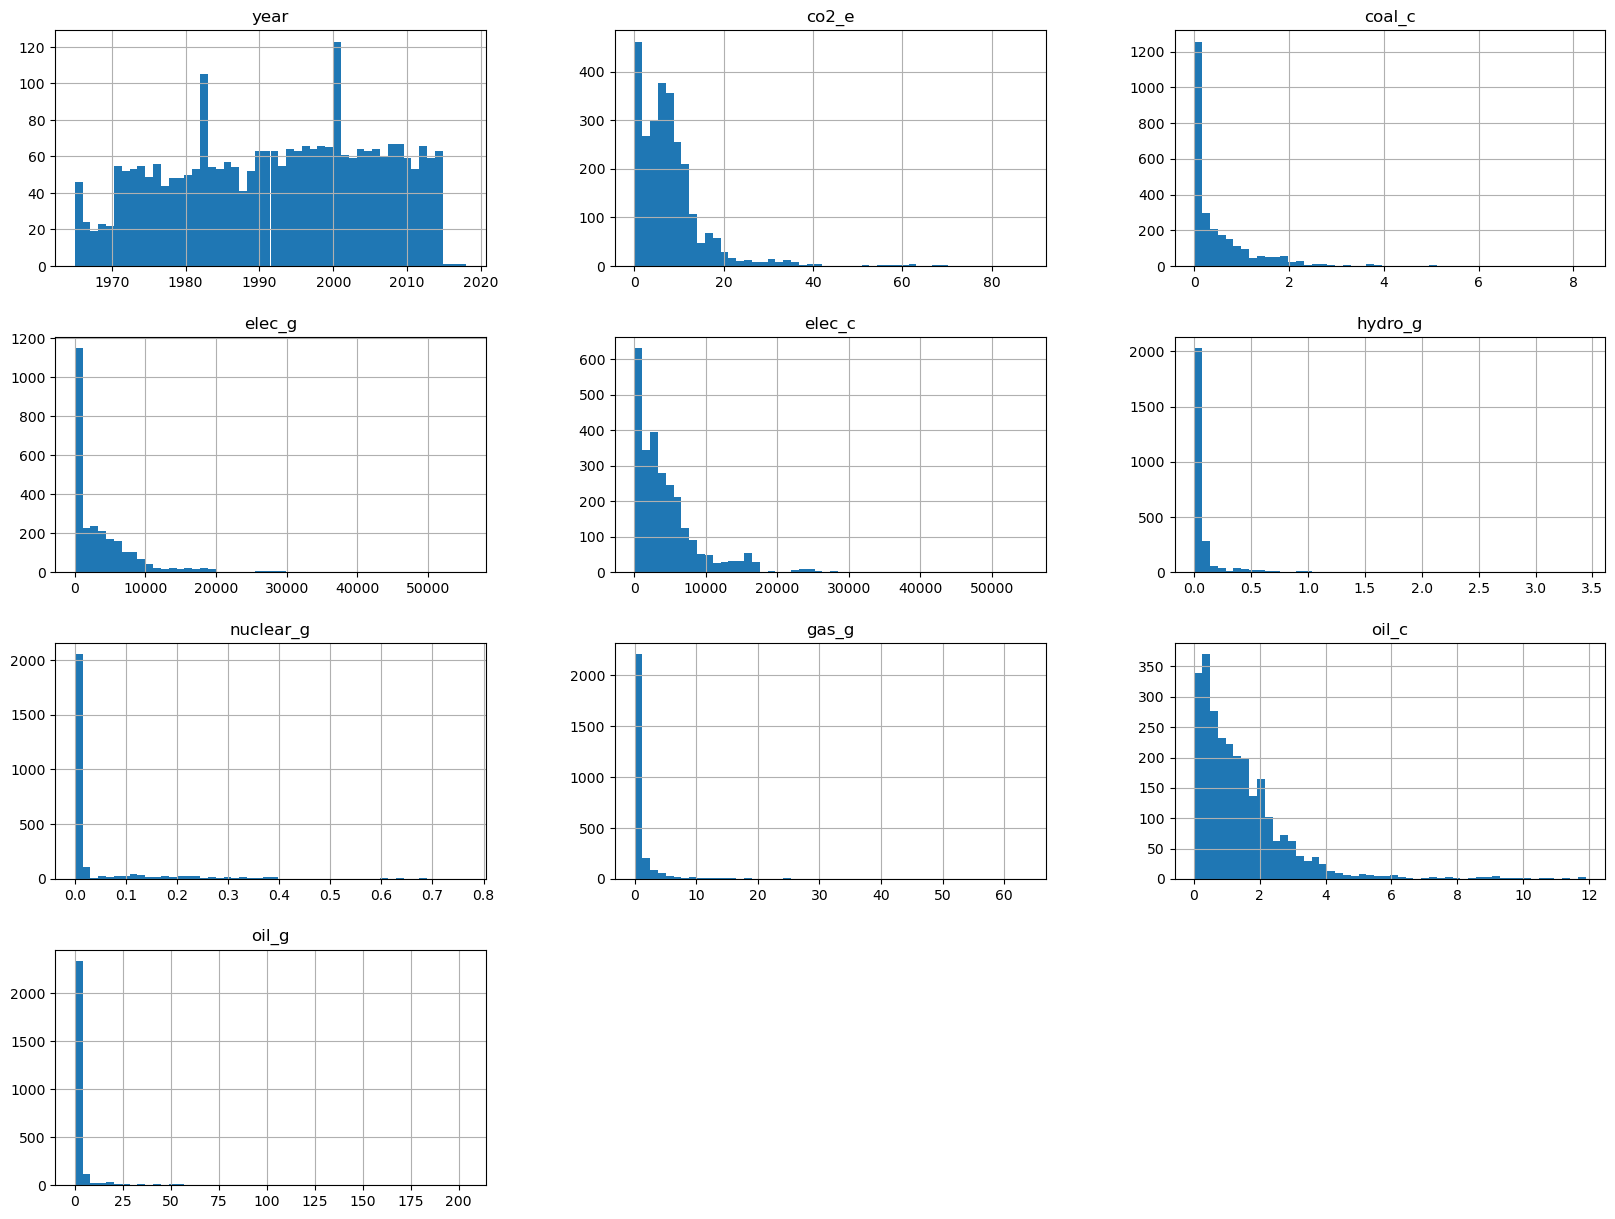

In [13]:
# Distributions for all numerical columns
train_df.hist(bins=50, figsize=(20, 15));

In [14]:
# distribution for each country
country_dist = alt.Chart(train_df).mark_bar().encode(
    alt.X('year').bin(maxbins=10),
    y='count()'
).properties(
    width=100,
    height=100
).facet(
    'country',
    columns=6
)

country_dist.display()

alt.FacetChart(...)

The Spearmean's rank correlation test below revealed some potential correlations between the following columns: co2_e vs elec_c, co2_e vs oil_c, elec_c vs oil_c, and gas_g vs oil_g.

In [15]:
# finding potential correlation between numeric columns
num_col = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

train_df[num_col].corr('spearman').style.background_gradient()

,year,co2_e,coal_c,elec_g,elec_c,hydro_g,nuclear_g,gas_g,oil_c,oil_g
year,1.000000,0.038270,0.003105,0.703007,0.253719,-0.168216,0.007491,0.156081,-0.028600,0.065862
co2_e,0.038270,1.000000,0.451953,0.423597,0.820880,-0.028447,0.227988,0.204832,0.813402,0.135448
coal_c,0.003105,0.451953,1.000000,0.222267,0.481075,0.274282,0.395342,-0.264986,0.223110,-0.399298
elec_g,0.703007,0.423597,0.222267,1.000000,0.641311,0.031603,0.226693,0.131033,0.363130,0.043299
elec_c,0.253719,0.820880,0.481075,0.641311,1.000000,0.220219,0.336324,0.025810,0.817716,-0.041407
hydro_g,-0.168216,-0.028447,0.274282,0.031603,0.220219,1.000000,0.344484,-0.171269,0.074902,-0.116532
nuclear_g,0.007491,0.227988,0.395342,0.226693,0.336324,0.344484,1.000000,-0.105993,0.207310,-0.212455
gas_g,0.156081,0.204832,-0.264986,0.131033,0.025810,-0.171269,-0.105993,1.000000,0.057477,0.827189
oil_c,-0.028600,0.813402,0.223110,0.363130,0.817716,0.074902,0.207310,0.057477,1.000000,0.073409
oil_g,0.065862,0.135448,-0.399298,0.043299,-0.041407,-0.116532,-0.212455,0.827189,0.073409,1.000000


We further visualized the correlation between columns of interest above in scatter plots. The plots also revealed that we only have one data point for year 2015 to 2018, we can consider exclude these years in the training dataset.

In [16]:
# co2_e (co2_emissions_tonnes_per_person) vs elec_e (electricity_use_per_person)
# function 2

create_scatter_plot(train_df, 'co2_e', 'elec_c', 'country')

alt.Chart(...)

In [17]:
# co2_e (co2_emissions_tonnes_per_person) vs oil_c (oil_consumption_per_cap)

create_scatter_plot(train_df, 'co2_e', 'oil_c', 'country')

alt.Chart(...)

In [18]:
# elec_c (electricity_use_per_person) vs oil_c (oil_consumption_per_cap)

create_scatter_plot(train_df, 'elec_c', 'oil_c', 'country')

alt.Chart(...)

In [19]:
# gas_g (natural_gas_production_per_person) vs oil_g (oil_production_per_person)

create_scatter_plot(train_df, 'gas_g', 'oil_g', 'country')

alt.Chart(...)

##### EDA Conclusion

We have changed the data type to appropriate type and unified the units for each column. We visualized the distribution for all numeric columns and explore potential correlation between columns. We split df into train and test data set (8:2) For pipeline building, it will be beneficial to remove the year 2015 - 2017 because we only have one data point per year. 

#### Export train and test data

In [20]:
train_df.to_csv('../data/processed/train_df.csv', index=True)
test_df.to_csv('../data/processed/test_df.csv', index=True)

#### Splitting X and y from train and test data

In [21]:
X_train = train_df.drop(columns=["co2_e"])
X_test = test_df.drop(columns=["co2_e"])
y_train = train_df["co2_e"]
y_test = test_df["co2_e"]

#### Preprocessing

Based on the nature of the data and the EDA results, the following assumption and preprocessing would be made
- A **naive assumption** that there is no temporal dependency between observations (i.e. observations among years) is made. `year` would be removed to prevent the model from exploiting the temporal feature for future-looking. Temporal feature treatment, e.g. time series split and time series cross-validation, could be considered later
- Scaling will be applied to all numeric features to standardize them to a common scale.
- OneHotEncoding will be applied to the categorical feature `country`.

In [22]:
# Lists of feature names
drop_feats = ['year']
categorical_feats = ['country']
numerical_feats = ['coal_c', 'elec_g', 'elec_c', 'hydro_g', 'nuclear_g', 'gas_g', 'oil_c', 'oil_g']

# Create the column transformer
# function 3
preprocessor = data_preprocessor(drop_feats=drop_feats, categorical_feats=categorical_feats, numerical_feats=numerical_feats)

preprocessor

ColumnTransformer(transformers=[('drop', 'drop', ['year']),
                                ('standardscaler', StandardScaler(),
                                 ['coal_c', 'elec_g', 'elec_c', 'hydro_g',
                                  'nuclear_g', 'gas_g', 'oil_c', 'oil_g']),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['country'])],
                  verbose_feature_names_out=False)

#### Model Training

We used various regression models with $ \text{R}^ 2 $ as the scoring metrics and carry out 10-fold cross-validation with each model to find the best performing models. Based on the validation results, the model using k-nearest neighbors (k-nn) 
algorithm is the best performing model with $ \text{R}^ 2 $ of 0.949.

In [23]:
models = {
    "Baseline": DummyRegressor(),
    "KNN_reg": KNeighborsRegressor(),
    "Ridge": Ridge(),
    "SVR": SVR(),
}
score_types = {
    "r2": "r2",
}

In [24]:
cross_val_results = dict()

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    cross_val_results[name] = (
        pd.DataFrame(
            cross_validate(
                pipe,
                X_train,
                y_train,
                cv=10,
                scoring=score_types,
                return_train_score=True,
            )
        )
        .agg(["mean", "std"])
        .round(3)
        .T
    )

cross_val_results_df = pd.concat(
    cross_val_results,
    axis="columns"
)
cross_val_results_df

Baseline        KNN_reg         Ridge           SVR       
               mean    std    mean    std   mean    std   mean    std
fit_time      0.031  0.007   0.031  0.004  0.050  0.010  4.160  0.129
score_time    0.013  0.002   0.143  0.081  0.012  0.001  0.596  0.020
test_r2      -0.003  0.004   0.953  0.022  0.915  0.021  0.714  0.057
train_r2      0.000  0.000   0.975  0.003  0.926  0.002  0.726  0.006

#### Hyperparameter Optimization

The hyperparameter `n_neighbors` and `max_categories` was chosen using 10-fold cross validation with  $ \text{R}^2 $ as the classification metric to improve the model performance. Based on the validation results, the KNN model has achieved a $ \text{R}^2 $(`mean_test_r2`) of 0.975.

In [25]:
param_dist = {
    "kneighborsregressor__n_neighbors": randint(1, 20),
    "columntransformer__onehotencoder__max_categories": randint(1, X_train['country'].unique().shape[0])
}

pipe_best_model = make_pipeline(preprocessor, KNeighborsRegressor())

random_search = RandomizedSearchCV(
    pipe_best_model,
    param_distributions=param_dist,
    cv=10,
    n_iter=100,
    scoring=score_types,
    n_jobs=-1,
    refit="r2",
    return_train_score=True,
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('drop',
                                                                               'drop',
                                                                               ['year']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['coal_c',
                                                                                'elec_g',
                                                                                'elec_c',
                                                                                'hydro_g',
                                                                                'nuclear_g',
                                                                                'gas_g',
                                                                                'oil_c',
                                                                                'oil_g']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(dtype='int',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['country'])],
                                                                verbose_...
                                              KNeighborsRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'columntransformer__onehotencoder__max_categories': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x4090937390>,
                                        'kneighborsregressor__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x4092a6aa10>},
                   refit='r2', return_train_score=True, scoring={'r2': 'r2'})

In [36]:
pd.DataFrame(random_search.cv_results_)[['param_columntransformer__onehotencoder__max_categories', 
                                         'param_kneighborsregressor__n_neighbors', 
                                         'mean_test_r2', 
                                         'std_test_r2']].sort_values('mean_test_r2', ascending=False)

,param_columntransformer__onehotencoder__max_categories,param_kneighborsregressor__n_neighbors,mean_test_r2,std_test_r2
90,25,1,0.975300,0.013455
84,44,1,0.975022,0.013742
52,42,1,0.974773,0.013706
97,50,1,0.974356,0.013915
7,73,1,0.974157,0.013957
...,...,...,...,...
88,46,18,0.895029,0.021465
44,50,19,0.894253,0.022337
59,42,19,0.892560,0.023245
35,9,18,0.892094,0.022809


In [27]:
# Scaled data export
scaled_X_train = random_search.best_estimator_.named_steps['columntransformer'].transform(X_train)
scaled_X_test = random_search.best_estimator_.named_steps['columntransformer'].transform(X_test)

scaled_X_train = pd.DataFrame(scaled_X_train, columns=random_search.best_estimator_.named_steps['columntransformer'].get_feature_names_out().tolist(), 
                              index=X_train.index)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=random_search.best_estimator_.named_steps['columntransformer'].get_feature_names_out().tolist(), 
                             index=X_test.index)

scaled_X_train.to_csv("../data/processed/scaled_save_the_earth_train_data.csv", index=True)
scaled_X_test.to_csv("../data/processed/scaled_save_the_earth_test_data.csv", index=True)

In [28]:
random_search.best_params_

{'columntransformer__onehotencoder__max_categories': 25,
 'kneighborsregressor__n_neighbors': 1}

#### Test Results

In [29]:
random_search.score(X_test, y_test)

0.975645926748788

In [30]:
# predicting the values for X_test
predicted = random_search.predict(X_test)
actual = pd.DataFrame(y_test)
actual.reset_index(inplace = True, drop = True)
# adding the predicted and actual values to a data frame
result = pd.DataFrame(predicted, columns = ['predicted'])
result['actual'] = actual

#saving the predictions vs actual file
result.to_csv("../data/processed/predictions_vs_actual.csv", index=False)

In [33]:
# calculating the root mean squared error and r2 score for training & test data
# function 4

scoring_metrics(random_search, X_train, y_train, X_test, y_test)

,train_rmse,test_rmse,train_r2,test_r2
0,0.0,1.349134,1.0,0.975646


Text(0.5, 1.0, 'Predicted Vs Actual values in Training Data')

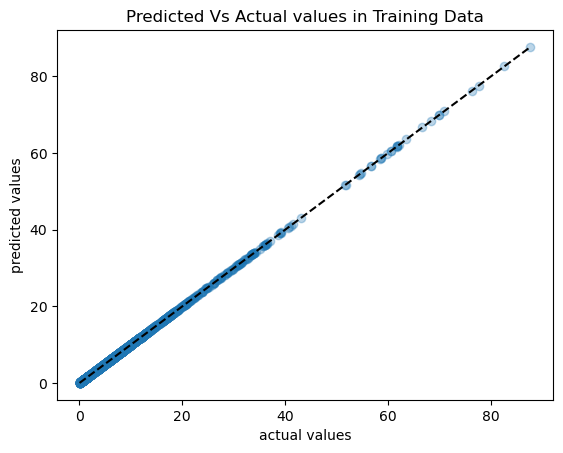

In [34]:

plt.scatter(y_train, random_search.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("actual values")
plt.ylabel("predicted values");
plt.title("Predicted Vs Actual values in Training Data")

Text(0.5, 1.0, 'Predicted Vs Actual values in Test data')

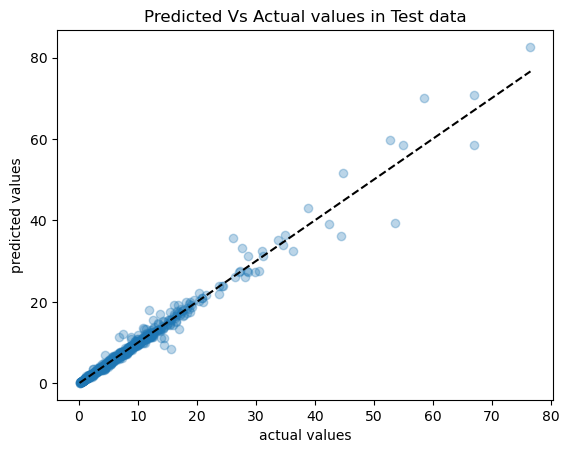

In [35]:
plt.scatter(y_test, random_search.predict(X_test), alpha=0.3)
grid = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("actual values")
plt.ylabel("predicted values");
plt.title("Predicted Vs Actual values in Test data")

From the test data plot, we can see that we are under predicting few values. Our model has the accuracy of 97.5% with minimal prediction errors. Our prediction model performed quite well on test data, with a final overall $\text{R}^2$ of 0.976, which is promising for predicting a country's CO2 emission per capita given the energy generation and consumption data. Our model has not less deviation from residual to the ground truth,as we have RMSE of 1.34 which is not too high for our models and it helps for reducing errors.

## Limitations and Future Direction

To further improve this model in future with hopes of arriving one that could be used, there are several improvements we can suggest for later revision.As mentioned in Preprocessing, there could possibly be temporal dependency between observations and temporal treatments could be considered. In the EDA above, we discovered there are collinearity between `oil_c` and `elec_c`, `oil_g` and `gas_g`. Though it might not affect the predictive power of models, it harms the interpretation of the coefficients of linear models. Collinearity reduction treatment e.g. feature removal, dimension reduction technique, etc., could be considered. Assumed that co2_emission might be still in increasing trend in the future, KNN may not predict well beyond the range of values input in your training data. Other models with similar predictive power which can predict out-of-range input data could be considered.

# References

Morice, C.P., J.J. Kennedy, N.A. Rayner, J.P. Winn, E. Hogan, R.E. Killick, R.J.H. Dunn, T.J. Osborn, P.D. Jones and I.R. Simpson (in press) An updated assessment of near-surface temperature change from 1850: the HadCRUT5 dataset. Journal of Geophysical Research (Atmospheres)

Hannah Ritchie, Max Roser and Pablo Rosado (2020) - "CO₂ and Greenhouse Gas Emissions". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/co2-and-greenhouse-gas-emissions'

IPCC, 2014: Climate Change 2014: Synthesis Report. Contribution of Working Groups I, II and III to the Fifth Assessment Report of the Intergovernmental 
Panel on Climate Change. IPCC, Geneva, Switzerland, 151 pp.

IPCC, 2018: Global Warming of 1.5°C. An IPCC Special Report.

International Energy Agency, 2018: World Energy Outlook 2018.
